In [1]:
#import user modules
#--- MATPLOTLIB
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd

import sys
my_path = "../../Python/"
if my_path not in sys.path:
    sys.path.append(my_path)
 
for place in sys.path: 
    print(place)

from fit_funcs import *
import costfun.costfun as cost
import utils.figures as fig_help
from RandomMatrixTheory import goe

import importlib as imp
def reload_modules():
    imp.reload(cost)
    imp.reload(fig_help)

import itertools
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
latex_engine = 'xelatex'
latex_elements = {'preamble':r'\usepackage{physics}'}

%matplotlib inline
colors_ls = (list(mcolors.TABLEAU_COLORS)[:200])
colors_ls_cyc = itertools.cycle(colors_ls)

markers_ls = ['o','s','v', 'D', '<', 'X', '^', '*', '+']
markers = itertools.cycle(markers_ls)

#--- NUMERICAL LIBS
import numpy as np
import itertools
import math
import random
from cmath import nan
import h5py   


# SCIPY LIBS
import scipy.stats as statistics
from scipy.special import binom
from scipy.special import erfinv
from scipy.special import digamma
from scipy.special import polygamma
from scipy.special import lambertw
from scipy.optimize import curve_fit as fit
from scipy.signal import savgol_filter
from scipy import integrate
from scipy import fft
 
# OTHER
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel, delayed
import copy
import os
from os import sep as kPSep
from os.path import exists


base_dir = "../results/PBC/"


/Users/rafal.swietek/Projects/QHamSolver/Anderson/Jupyter_Python
/Users/rafal.swietek/opt/anaconda3/lib/python39.zip
/Users/rafal.swietek/opt/anaconda3/lib/python3.9
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/lib-dynload

/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/aeosa
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/locket-0.2.1-py3.9.egg
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions
/Users/rafal.swietek/.ipython
../../Python/


In [2]:

def order_of_magnitude2(a_value):
    #return 2
    if np.abs(a_value) < 1.0 and a_value != 0:
        m = np.abs(np.log10(np.abs(a_value)))
        return int(max(math.ceil(m) + 1., 2.))
    else: 
        return 2

def order_of_magnitude(a_value):
    x = a_value - int(a_value)
    x = np.round(x, 8)
    num_str = f"{x}"
    num_str = num_str[2:]
    _size = len(num_str)
    if num_str == "0":
        _size = 0;
    
    return _size
    
def info_raw(L, J, w, use_old = False):
    arr = [J, w]
    names = ['J', 'w']
    info = "_L=%d"%(L)
    for i, var in enumerate(arr):
        n = order_of_magnitude2(var) if use_old else order_of_magnitude(var)
        info += str(",%s={:.%df}"%(names[i], n)).format(round(var, n))
    return info

def info(L, J, w, use_old = False, ext = '.dat'):
    return info_raw(L, J, w, use_old) + ext


def GOE(x : np.array):
    """
    GOE shape of sff in thermodynamic limit
    
    Parameters:
    -----------------
        x : np.array
            numpy array with datapoints (times defined for unfolded data)
    """
    return np.array([2 * a - a * np.log(1 + 2 * a) if a < 1 else 2 - a * np.log( (2 * a + 1) / (2 * a - 1) ) for a in x])

def remove_fluctuations(data, bucket_size=10):
    new_data = data;
    half_bucket = int(bucket_size / 2)
    for k in range(half_bucket, len(data) - half_bucket):
        average = np.sum(data[k - half_bucket : k + half_bucket])
        new_data[k - half_bucket] = average / bucket_size
    return new_data


def page(L_a, L_b):
    return L_a * np.log(2)
    d_a = 2**L_a
    d_b = 2**L_b
    print(d_a, L_a)
    print(d_b, L_b)
    return digamma(d_a * d_b + 1) - digamma(max(d_a, d_b) + 1) - (min(d_a, d_b) - 1) / (2 * max(d_a, d_b))

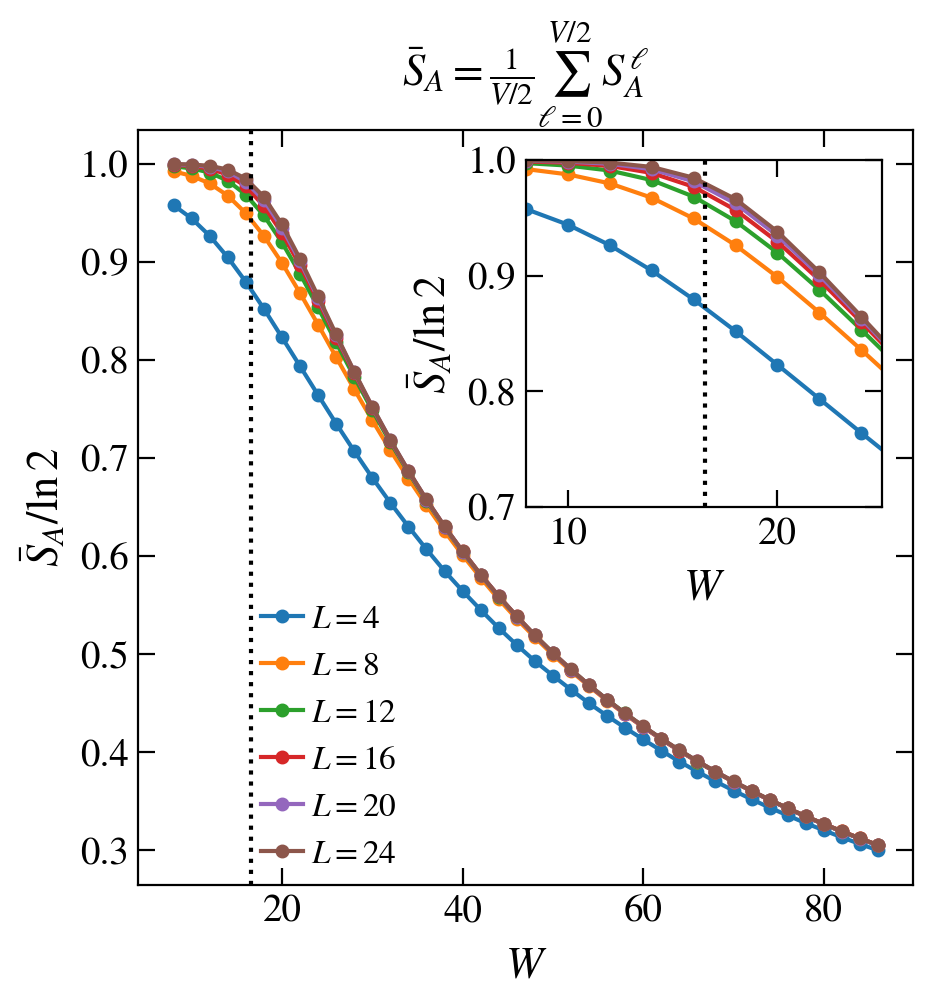

In [3]:
L = 20
w = 2
J = 1

w_vals = np.linspace(2.0, 21.5, 40)

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)

ax_inset = fig_help.add_subplot_axes(axis, fig, [0.5, 0.5, 0.46, 0.46])
def frac(dim):
    return 500

Wc = 16.54
for L in np.arange(4, 25, 4):
    V = L**3
    

    S_site = np.zeros((w_vals.size))
    for ii, w in enumerate(w_vals):
        name = base_dir + 'Entropy/Eigenstate/' + info(L=L, J=J, w=w, ext='.hdf5')
        #print(name)
        if exists(name):
            with h5py.File(name, "r") as file:
                S = np.mean(np.array(file.get('single_site_entropy')))
                S_site[ii] = S
        else:
            S_site[ii] = np.nan
            print(name)
    
    ydata = S_site / page(1, V - 1)
    axis.plot(4 * w_vals, ydata, marker='o', markersize=4, label=r"$L=%d$"%(L))
    
    ax_inset.plot(4 * w_vals, ydata, marker='o', markersize=4, label=r"$L=%d$"%(L))

axis.axvline(x=Wc, ls=':', color='black')
ax_inset.axvline(x=Wc, ls=':', color='black')
fig_help.set_plot_elements(axis, ylabel=r"${\bar{S}_A} / \ln2$", xlabel=r"$W$", font_size=14, set_legend=True)
axis.legend(loc = 'lower left', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.12,-0.02))

fig_help.set_plot_elements(ax_inset, ylabel=r"${\bar{S}_A} / \ln2$", xlabel=r"$W$", font_size=14, set_legend=False, xlim=(8.0, 25.0), ylim=(0.7, 1.0))

axis.set_title(r"$\bar{S}_A=\frac{1}{V/2}\sum_{\ell=0}^{V/2} S_A^\ell$", fontsize=16)
fig.subplots_adjust(wspace = 0.2, hspace=0.05)

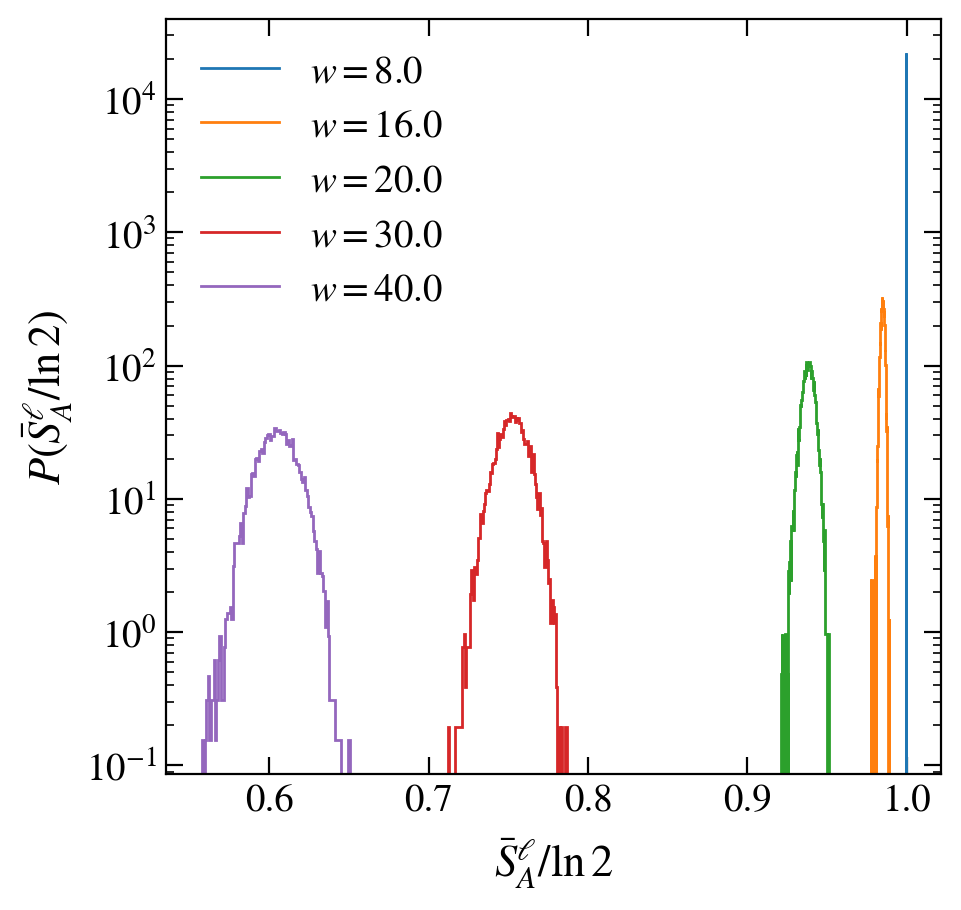

In [5]:
L = 24
w = 2
J = 1

w_vals = np.linspace(2.0, 21.5, 40)

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)

def frac(dim):
    return 500

Wc = 16.54
V = L**3


nbins = 100

w_vals = [2., 4.0, 5.0, 7.5, 10.0]
for ii, w in enumerate(w_vals):
    name = base_dir + 'Entropy/Eigenstate/' + info(L=L, J=J, w=w, ext='.hdf5')
    #print(name)
    if exists(name):
        with h5py.File(name, "r") as file:
            S = np.array(file.get('single_site_entropy')) / np.log(2)
            hist, edge = np.histogram(S, bins=nbins, normed=True)
            axis.stairs(hist, edge, label=r"$w=%.1f$"%(4*w))

    else:
        print(name)


fig_help.set_plot_elements(axis, ylabel=r"$P(\bar{S}^\ell_A / \ln2)$", xlabel=r"$\bar{S}^\ell_A / \ln2$", font_size=14, set_legend=True, yscale='log')
# axis.legend(loc = 'lower left', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02,-0.02))
fig.subplots_adjust(wspace = 0.2, hspace=0.05)